<font size = 5, color='##4682B4' ><b><center>BERT Topic Modeling-Federal Reserve</font>
<ul>
<font size = 3>
<a href = "#section1"><li>1. Load Dataset</li></a>
<a href = "#section2"><li>2. Preprocessing text Column</li></a>
    <a href = "#section2.1"><ul><li>2.1 Clean text column for topic modeling</li></ul></a>
    <a href = "#section2.2"><ul><li>2.2 WordCloud</li></ul></a>
<a href = "#section3"><li>3. BERT Topic Modeling</li></a>
    <a href = "#section3.1"><ul><li>3.1 BERTopic modeling with default setting</li></ul></a>
    <a href = "#section3.2"><ul><li>3.2 Tuning BERTopic model parameter-n_neighbors</li></ul></a>
    <a href = "#section3.3"><ul><li>3.3 Tuning BERTopic model parameter-nr_topics</li></ul></a>
    <a href = "#section3.4"><ul><li>3.4 Get the Optimal BERTopic model</li></ul></a>
    <a href = "#section3.5"><ul><li>3.5 Visualizations</li></ul></a>
<a href = "#section4"><li>4. Conclusion</li></a>
        
</ul>

<font size = 4><b><center><a id="section1">1. Load Dataset</a>

<font color='##4682B4' size = 3>Pool dataset into jupyter notebook from Google SQL, credential file is named macrox.json. <br>
    All seven streams are included in the tables list, this file will focus on Trader Influencers dataset only </font>

In [1]:
#pip install gcsfs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys

import re,string #deal with special characteristics in hashtag and text

import datetime
from timeit import default_timer as timer    

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'macrox.json'

tables = ['twitter_stream_macro_institutions',
 'twitter_stream_econ_news',
 'twitter_stream_investment_communities',
 'twitter_stream_us_politicians',
 'twitter_stream_federal_reserve',
 'twitter_stream_india_covid',
 'twitter_stream_trader_influencers']

In [3]:
##Choose Federal Reserve Stream as pd
df = pd.read_csv('gs://capstone_twitter/capstone/' + tables[4] + '.csv', index_col= 0)

In [4]:
##convert the 'created_at' colunm to datetime format
df_bert = df.copy()
df_bert['Date'] = pd.to_datetime(df_bert['created_at']).dt.date

In [5]:
## choose the time duration 
earliest_date = datetime.date(2021, 6, 15)

latest_date= datetime.date(2021, 6, 30)

In [6]:
#filter for 15 days 
df_model = df_bert[(df_bert['Date'] >= earliest_date)&(df_bert['Date'] <= latest_date)]
len(df_model)

13058

<font size = 4><b><center><a id="section2">2. Preprocessing text Column</a>

<font size = 4><b><center><a id="section2.1">2.1 Clean text column for topic modeling</a>

In [7]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [8]:
#Add the directory that contains the preprocessing.py module to the system path for import 
base_dir = os.getcwd() #get the current working directory 
sys.path.insert(0,base_dir)

In [9]:
import preprocessing ## import preprocessing function
from preprocessing import stop_words,nlp
import string

In [10]:
## remove links ##
def strip_links(text):
    link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], '')    
    return text

## remove all entities ##
def strip_all_entities(text):
    entity_prefixes = ['@','_']
    for separator in string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

##remove numbers##
def remove_number(text):
    return re.sub("\S*\d\S*", "", text).strip()

##remove stopwords##
def remove_stops_words(text):
    text = [w for w in text if not w in list(stop_words)] #remove stopwords
    return text
## remove punctuations##
def remove_punc(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [11]:
## define a clean function to clean all links, entities and numbers from text
def clean_text(text):
    text = strip_links(text)
    text = strip_all_entities(text)
    text = remove_number(text)
    return text

In [12]:
## define a function by using preprocessing function to do deep cleaning 
def pre_process(df):
    df['clean_text'] = df['text'].apply(clean_text)
    df['clean_text'] = df['clean_text'].str.lower()
    df['clean_text'] = df.clean_text.str.replace('’',"\'")
    df['clean_text'] = df.clean_text.str.replace('#',"").str.replace('$',"").str.replace('%',"").str.replace("-"," ").str.replace("…","")
#     eco['clean_text'] = eco.clean_text.str.replace('u.s.',"usa").str.replace('u.s.a.',"usa")
    df['clean_text'] = df.clean_text.apply(preprocessing.remove_whitespace)
    df['clean_text'] = df.clean_text.apply(lambda x: preprocessing.find_urls(x,rm=True))
    df['clean_text'] = df.clean_text.apply(lambda x: preprocessing.find_emojis(x,rm=True))
    df['clean_text'] = df.clean_text.apply(preprocessing.expand_contractions) #this expands possessie contractions to '... is'
    df['clean_text'] = df.clean_text.apply(preprocessing.remove_apostrophe) #remove any lingering appostrophes in accents or informal abbreviations.
    df['clean_text'] = df.clean_text.apply(preprocessing.remove_handles)
    df['clean_text'] = df.clean_text.apply(remove_punc)
    df['clean_text'] = df.clean_text.apply(tknzr.tokenize)
    df['clean_text'] = df.clean_text.apply(remove_stops_words)

In [13]:
%%time
pre_process(df_model)

CPU times: user 7.21 s, sys: 42.6 ms, total: 7.26 s
Wall time: 7.26 s


In [14]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [15]:
%%time
data_lemmatized = lemmatization(df_model.clean_text.to_list(), allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

CPU times: user 23.4 s, sys: 63.1 ms, total: 23.4 s
Wall time: 23.5 s


In [16]:
print(data_lemmatized[:5])

['inflation month love guy understand complexity move part cdnecon inflation', 'type accidentally inflation bad', 'woman watch simonebile britneyspear', 'inflation', 'polarise pretty bunker camp']


In [17]:
## define a function that just aloow noun as output
def keep_noun(texts, allowed_postags=['NOUN']):
    texts_out = []
    for i in texts:
        doc = nlp(i) 
        texts_out.append(" ".join([str(token) for token in doc if (token.pos_ in allowed_postags or '_' in str(token)) ]))
    return texts_out

In [18]:
%%time
data_bert = keep_noun(data_lemmatized)

CPU times: user 18.4 s, sys: 28.7 ms, total: 18.5 s
Wall time: 18.5 s


In [19]:
data_bert[:5]

['inflation guy complexity part cdnecon inflation',
 'inflation',
 'woman',
 'inflation',
 'polarise bunker camp']

<font size = 4><b><center><a id="section2.2">2.2 WordCloud</a>

In [20]:
from wordcloud import WordCloud

In [21]:
def wordcloud_func(words, Stop_Words = [], Twitter_Icon = False, feature_name = '', if_save = False):

    #set wordcloud style
    if Twitter_Icon:
        mask = np.array(Image.open(path.join(base_dir, "Twitter.png")))
        data_wordcloud = WordCloud(stopwords = Stop_Words, background_color = "white", collocations = False, 
                                   max_words = 100, contour_width=1,width=800, height=500, mask=mask)
    else:
         data_wordcloud = WordCloud(stopwords = Stop_Words, background_color = "white", collocations = False, 
                                   max_words = 100, contour_width=1,width=800, height=500)
    #produce wordcloud
    data_wordcloud.generate(words)
    #     wordcloud_image = data_wordcloud.to_image()
    plt.subplots(figsize=(15,12))
    plt.imshow(data_wordcloud, interpolation='bilinear')
    plt.title('Most used words in %s'%feature_name,fontweight ='bold', fontsize = 20)
    plt.axis("off")
    
    if if_save:
         plt.savefig('Most used words in %s'%feature_name, bbox_inches="tight")

    plt.show()

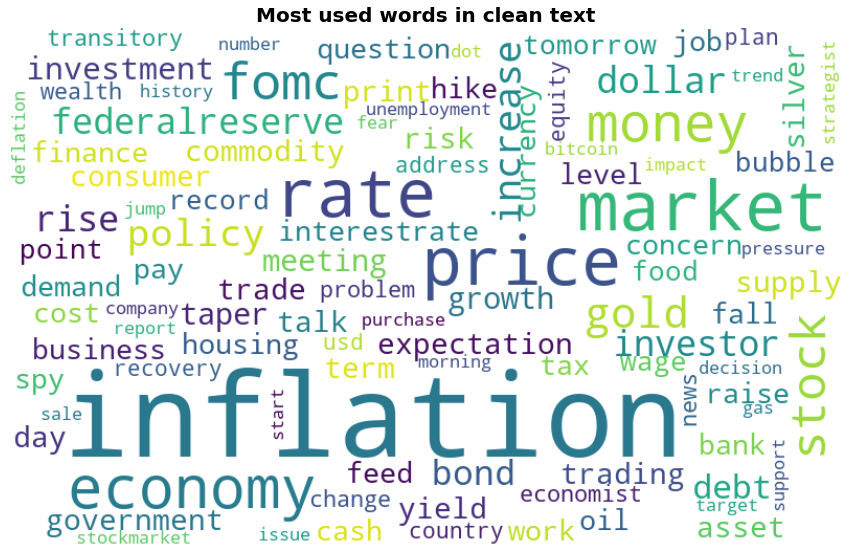

In [22]:
wordcloud_func(" ".join(data_bert), Stop_Words = ['people', 'year', 'time', 'thing', 'week', 'person', 'today',
                                                 'lot', 'amp', 'month', 'man'],
               Twitter_Icon = False, feature_name = 'clean text', if_save = False)

In [23]:
# delete some words that frequently shows but useless according from wordcloud 
Useless_Words_wc = ['people', 'year', 'time', 'thing', 'week', 'person', 'today',
                    'lot', 'amp', 'month', 'man', 'shit', 'suck', 'folk','hour',
                    'bruh','bit', 'congratulation', 'day', 'guy', 'matter', 'thought',
                    'tomorrow', 'morning', 'year_ago', 'dude', 'good_morning', 'feel',
                    'month_ago', 'yesterday', '•', 'age', 'fool', 'idiot', 'good_luck','zzzzzzz',
                   "yess", "letsgo","fuckboi","wait", "hear","notice","obv","talk_taper","baerplag","taxis"]

In [24]:
def remove_useless_words(text):
    text = [w for w in text if not w in Useless_Words_wc] #remove stopwords
    return text

In [25]:
data_for_modeling = [(remove_useless_words(text.split())) for text in data_bert]

In [26]:
data_for_modeling

[['inflation', 'complexity', 'part', 'cdnecon', 'inflation'],
 ['inflation'],
 ['woman'],
 ['inflation'],
 ['polarise', 'bunker', 'camp'],
 ['ticker'],
 ['cryptocurrency', 'inflation', 'level', 'flux', 'defi', 'good'],
 ['drug', 'covid'],
 ['reason', 'inflation'],
 ['inflation'],
 ['inflation',
  'financialliteracy',
  'inflation',
  'government',
  'economy',
  'tune'],
 ['paycheck',
  'protection',
  'program',
  'processing',
  'ppp',
  'business',
  'detail',
  'politician'],
 ['family',
  'cell',
  'shift',
  'attention',
  'scandal',
  'problem',
  'bordercrisis',
  'inflation'],
 ['mind', 'action', 'taker', 'face', 'crisis', 'inflation'],
 ['judgment',
  'deal',
  'dollar',
  'distribution',
  'mechanism',
  'decade',
  'sector',
  'stablecoin'],
 ['food', 'inflation'],
 [],
 ['price', 'food', 'gas', 'surge', 'inflation'],
 ['rmb', 'crisis', 'question'],
 ['gold', 'silver', 'index', 'print', 'inflation'],
 ['inflation'],
 ['fact',
  'consumer',
  'food',
  'price',
  'food',
  '

<font size = 4><b><center><a id="section3">3. BERT Topic Modeling</a>

In [27]:
data = [' '.join(txt) for txt in data_for_modeling]

In [28]:
data

['inflation complexity part cdnecon inflation',
 'inflation',
 'woman',
 'inflation',
 'polarise bunker camp',
 'ticker',
 'cryptocurrency inflation level flux defi good',
 'drug covid',
 'reason inflation',
 'inflation',
 'inflation financialliteracy inflation government economy tune',
 'paycheck protection program processing ppp business detail politician',
 'family cell shift attention scandal problem bordercrisis inflation',
 'mind action taker face crisis inflation',
 'judgment deal dollar distribution mechanism decade sector stablecoin',
 'food inflation',
 '',
 'price food gas surge inflation',
 'rmb crisis question',
 'gold silver index print inflation',
 'inflation',
 'fact consumer food price food price inflation increase pandemic',
 'restaurant price inflation edge',
 'fighting',
 'investor concern inflation labor shortage supply chain issue',
 'inflation tax income household restaurant paring item combo meal strategy employ lift sale profit rise food cost',
 'friend print m

<font size = 4><b><center><a id="section3.1">3.1 BERTopic Modeling with default setting </a>

In [29]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

In [30]:
# Load sentence transformer model
sentence_model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')#("roberta-base-nli-stsb-mean-tokens")

# Create documents embeddings
embeddings = sentence_model.encode(data, show_progress_bar=False)

In [31]:
# Create BERTopic model
topic_model = BERTopic()

# Train model, extract topics and probabilities
topics, probabilities = topic_model.fit_transform(data, embeddings)

### Get Coherence Score of Bertopic

In [32]:
def get_coherence_score(model):
    import gensim.corpora as corpora
    id2word = corpora.Dictionary(data_for_modeling)
    texts = data_for_modeling
    corpus = [id2word.doc2bow(text) for text in data_for_modeling if text !=[]]

    topic_list = []
    for j in range(len(model.get_topic_freq())-1):
        topic_list.append([i[0] for i in model.get_topic(j) if i[1]>=0.01])
    
    from gensim.models.coherencemodel import CoherenceModel

    coherence_model = CoherenceModel(topics=topic_list, texts=texts, corpus=corpus, dictionary=id2word, coherence='c_v')
    return coherence_model.get_coherence()

In [33]:
get_coherence_score(topic_model)

0.3860876439147227

<font size = 4><b><center><a id="section3.2">3.2 Tuning BERTopic model parameter-n_neighbors</a>

In [38]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_for_modeling)
texts = data_for_modeling
corpus = [id2word.doc2bow(text) for text in data_for_modeling if text !=[]]

In [39]:
# Define UMAP model to reduce embeddings dimension
## since it not easy to tuning parameters through those two models together
import umap
import hdbscan
umap_model = umap.UMAP(n_neighbors=10,
                       n_components=10,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory=False)

# Define HDBSCAN model to perform documents clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=30,
                                min_samples=1,
                                metric='l2',
                                cluster_selection_method='eom',
                                prediction_data=True)

In [40]:
def compute_coherence_values1(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values_topic = []
    model_list = []
    for i in range(start, limit, step):
        umap_model = umap.UMAP(n_neighbors=i,
                       n_components=10,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory=False)
        model = BERTopic(top_n_words=20,
                         nr_topics="auto",
                         calculate_probabilities=True,
                         umap_model= umap_model,
                         hdbscan_model=hdbscan_model,
                         verbose=True)

        # Train model, extract topics and probabilities
        topics, probabilities = model.fit_transform(data,embeddings)
        
        model_list.append(model)
        coherencemodel = get_coherence_score(model)
        coherence_values_topic.append(coherencemodel)

    return model_list, coherence_values_topic

In [41]:
%%time
model_list, coherence_values_topic = compute_coherence_values1(dictionary = id2word,
                                                                    corpus =corpus,
                                                                    texts = data,
                                                                    start=5, limit=15, step=1)

2021-12-13 14:05:45,797 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 14:05:52,675 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-13 14:05:53,243 - BERTopic - Reduced number of topics from 116 to 23
2021-12-13 14:06:10,405 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 14:06:16,738 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-13 14:06:17,278 - BERTopic - Reduced number of topics from 110 to 32
2021-12-13 14:06:34,918 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 14:06:41,193 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-13 14:06:41,699 - BERTopic - Reduced number of topics from 102 to 35
2021-12-13 14:07:00,717 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 14:07:06,550 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-13 14:07:07,061 - BERTopic - Reduced number of topics from 104 to 36
2021-12-13 14:07:24,940 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 14:07:31,007 - BERTopic - C

CPU times: user 6min 46s, sys: 8.1 s, total: 6min 54s
Wall time: 4min 13s


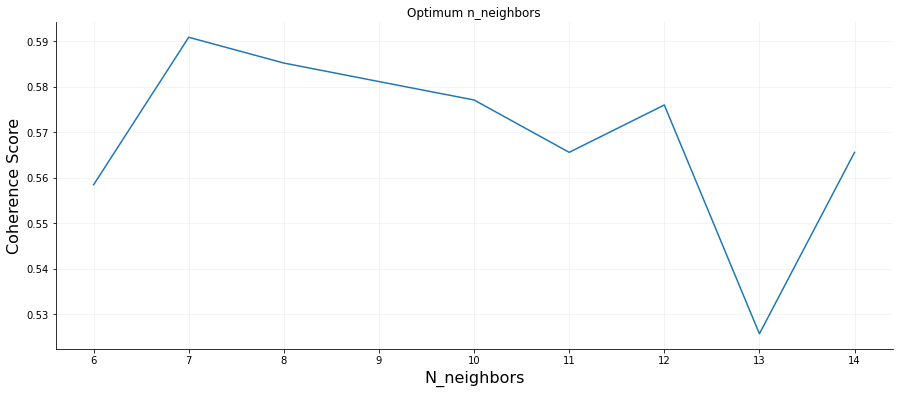

In [42]:
fig, ax = plt.subplots(1,1,figsize = (15,6))

ax.plot(list(range(5,15, 1)), coherence_values_topic,'-',markersize=2)
ax.grid(color = 'grey', alpha =0.1)
ax.set_title(('Optimum n_neighbors'))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_ylabel("Coherence Score", fontsize= 16)
ax.set_xlabel("N_neighbors", fontsize= 16)

plt.show() 

From this plot, when n_neighbors = 7, the coherence score is the highest one(optimal n_neighbors will change when restart and run)

<font size = 4><b><center><a id="section3.3">3.3 Tuning BERTopic model parameter-nr_topics</a>

In [43]:
#Defining a function to loop over number of topics to be used to find an 
#optimal number of tipics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values_topic = []
    model_list = []
    for i in range(start, limit, step):
        model = BERTopic(top_n_words=20,
                         nr_topics=i,
                         calculate_probabilities=True,
                         umap_model= umap_model,
                         hdbscan_model=hdbscan_model,
                         verbose=True)

        # Train model, extract topics and probabilities
        topics, probabilities = model.fit_transform(data,embeddings)
        
        model_list.append(model)
        coherencemodel = get_coherence_score(model)
        coherence_values_topic.append(coherencemodel)

    return model_list, coherence_values_topic

In [44]:
%%time
model_list, coherence_values_topic = compute_coherence_values(dictionary = id2word,
                                                                    corpus =corpus,
                                                                    texts = data,
                                                                    start=20, limit=30, step=1)

2021-12-13 14:09:59,735 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 14:10:04,832 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-13 14:10:05,388 - BERTopic - Reduced number of topics from 96 to 21
2021-12-13 14:10:23,113 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 14:10:28,878 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-13 14:10:29,462 - BERTopic - Reduced number of topics from 105 to 22
2021-12-13 14:10:46,900 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 14:10:53,081 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-13 14:10:53,644 - BERTopic - Reduced number of topics from 101 to 23
2021-12-13 14:11:12,150 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 14:11:18,339 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-13 14:11:18,895 - BERTopic - Reduced number of topics from 101 to 24
2021-12-13 14:11:37,144 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 14:11:43,363 - BERTopic - Cl

CPU times: user 6min 54s, sys: 10.2 s, total: 7min 4s
Wall time: 4min 10s


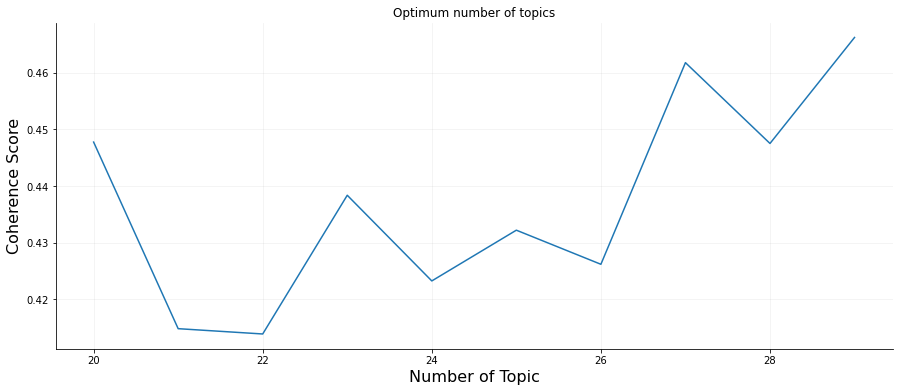

In [45]:
fig, ax = plt.subplots(1,1,figsize = (15,6))

ax.plot(list(range(20,30, 1)), coherence_values_topic,'-',markersize=2)
ax.grid(color = 'grey', alpha =0.1)
ax.set_title(('Optimum number of topics'))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_ylabel("Coherence Score", fontsize= 16)
ax.set_xlabel("Number of Topic", fontsize= 16)

plt.show() 

#### Compared with the mutually change the number of topic with the reduce dimensionality automatically, the latter one has the better result.

<font size = 4><b><center><a id="section3.4">3.4 Get the Optimal BERTopic Model</a>

In [46]:

# Load sentence transformer model
sentence_model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')#("roberta-base-nli-stsb-mean-tokens")

# Create documents embeddings
embeddings = sentence_model.encode(data, show_progress_bar=False)


In [47]:
# Define UMAP model to reduce embeddings dimension
import umap
import hdbscan
umap_model = umap.UMAP(n_neighbors=10,
                       n_components=7,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory=False)

# Define HDBSCAN model to perform documents clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=30,
                                min_samples=1,
                                metric='l2',
                                cluster_selection_method='eom',
                                prediction_data=True)

In [48]:
# Applying the BERTopic model
warnings.filterwarnings('ignore')
topic_model = BERTopic(top_n_words=20,
                       nr_topics="auto", ## reduce dimensionality automatically
                       calculate_probabilities=True,
                       umap_model= umap_model,
                       hdbscan_model=hdbscan_model,
                       verbose=True)

# Train model, extract topics and probabilities
topics, probabilities = topic_model.fit_transform(data,embeddings)

2021-12-13 14:19:19,357 - BERTopic - Reduced dimensionality with UMAP
2021-12-13 14:19:24,988 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-12-13 14:19:25,486 - BERTopic - Reduced number of topics from 102 to 37


In [49]:
get_coherence_score(topic_model)

0.5853579769516717

In [50]:
freq = topic_model.get_topic_info()
freq # from the result, number of topics = 28, the coherence score is the highest one

,Topic,Count,Name
0,0,5833,0_gold_commodity_investment_investor
1,-1,3832,-1_bond_business_stock_growth
2,1,1400,1_allyabuse_digit_mother_info
3,2,174,2_trading_manipulation_fomc_volatility
4,3,142,3_fomc_thefe_hmbl_fomo
5,4,133,4_meeting_fomc_policy_comment
6,5,112,5_comment_video_talk_answer
7,6,94,6_source_plan_pant_point
8,7,88,7_money_cash_method_wallet
9,8,84,8_truth_case_reality_reset


In [110]:
## see more detail of specific topic with probabilities
topic_model.get_topic(18)

[('tax', 0.6440259780869695),
 ('cut', 0.29933988357703645),
 ('refund', 0.15133636305217613),
 ('payer', 0.10089090870145075),
 ('return', 0.08590518959064078),
 ('corporation', 0.0827320278970192),
 ('pay', 0.08205716601710031),
 ('debt', 0.07750443973991449),
 ('charge', 0.07301654583252135),
 ('help', 0.068727104584834),
 ('treasurydepartment', 0.06374659412290802),
 ('sin', 0.06374659412290802),
 ('ballot', 0.06374659412290802),
 ('deliver', 0.058018105027371286),
 ('treasury', 0.058018105027371286),
 ('convert', 0.05466715372069224),
 ('indictment', 0.052289615931834545),
 ('reform', 0.05044545435072537),
 ('element', 0.05044545435072537),
 ('mail', 0.05044545435072537)]

<font size = 4><b><center><a id="section3.5">3.5 Visualizations</a>

In [111]:
### visualize the intertopic distance 
topic_model.visualize_topics()

In [112]:
### get barplot of each topics and ther probabilities
topic_model.visualize_barchart(topics=range(0,6),
                       n_words=6,
                       width=800,
                       height=400)

In [113]:
## get the timeseries patterns for output topics
timestamps = df_model['Date'].to_list()

In [114]:
topics_over_time = topic_model.topics_over_time(data, topics, timestamps)

13it [00:00, 24.00it/s]


In [115]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[0,1,2,3,4,5,6])

<font size = 4><b><center><a id="section4">4. Conclusion</a>